# Models Comparison for TinyML

In [5]:
# Load libraries
import numpy as np
from numpy import arange
import pickle

#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import sys
import seaborn as sbs

warnings.filterwarnings('ignore')

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

## Change 'chosenIndex' to change the chosen Test (s/s3/s6)

In [7]:
dataXPath = ['../data/X.pkl', '../data/XS3.pkl', '../data/XS6.pkl']
dataYPath = ['../data/y.pkl', '../data/yS3.pkl', '../data/yS6.pkl']
choosenIndex = 2

with open(dataXPath[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(dataYPath[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [10]:
print(np.unique(y))
labels = [str(el) for el in list(np.unique(y))]
print(labels)

[2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000]
['2000', '2100', '2200', '2300', '2400', '2500', '2600', '2700', '2800', '2900', '3000']


In [5]:
# Convert the labels in values like 0...n for the NN tests

labels = []
uniques = list(np.unique(y))

[labels.append(uniques.index(el)) for el in y]

y = np.array(labels)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [39]:
print(X_test)

[[4285.7  4294.7  4306.07 4293.05 4286.88 4312.93 4301.12 4287.5  4284.17
  4290.04 4285.91 4269.82 4283.57 4264.58 4259.01 4268.87 4246.28 4241.
  4245.03 4236.4  4226.57 4236.02 4231.11 4218.93 4228.91 4229.2  4215.02
  4215.3  4214.23 4204.33 4204.88 4209.74]
 [4002.17 4015.39 4018.22 4015.45 4016.49 4028.62 4032.57 4026.54 4027.87
  4029.12 4038.97 4038.42 4029.67 4036.72 4036.27 4039.25 4029.92 4038.12
  4039.1  4041.64 4040.98 4042.86 4039.91 4048.86 4053.43 4053.   4054.18
  4053.5  4055.97 4057.14 4057.02 4063.76]
 [5257.57 5255.8  5257.39 5218.43 5261.56 5252.22 5241.1  5202.98 5263.5
  5186.01 5237.17 5252.8  5204.57 5229.22 5210.17 5241.79 5208.13 5210.38
  5218.85 5226.97 5264.2  5170.76 5247.67 5202.49 5187.13 5157.64 5175.31
  5161.65 5183.45 5260.1  5194.25 5213.14]
 [4651.56 4657.4  4666.16 4644.15 4662.31 4664.16 4654.97 4659.11 4669.47
  4650.75 4661.73 4665.12 4661.75 4659.81 4674.65 4656.95 4659.17 4670.53
  4666.99 4663.3  4676.72 4664.78 4666.05 4681.82 4683.45 46

## Model Spotting

In [8]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [9]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [10]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,52 0,04
LR - 0,10 0,04
CART - 0,55 0,06
SVC - 0,11 0,01
RF - 0,65 0,05


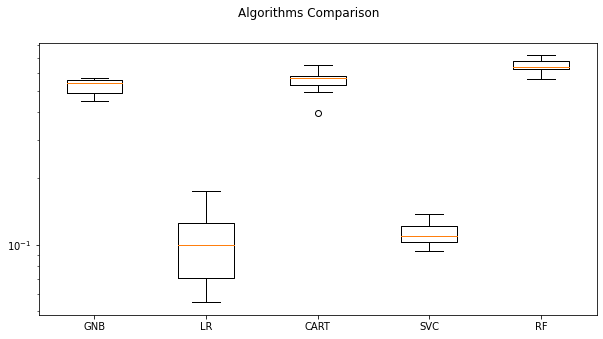

In [11]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_yscale('log')
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [12]:
tasks = ['S', 'S3', 'S6']
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/classificationReports/'+'classification_report' + model_name +  '.csv', index = False)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        20
           1       1.00      0.90      0.95        20
           2       0.18      0.10      0.13        20
           3       0.88      0.70      0.78        20
           4       0.37      0.50      0.43        20
           5       0.00      0.00      0.00        20
           6       0.79      0.95      0.86        20
           7       0.47      0.70      0.56        20
           8       0.54      0.70      0.61        20
           9       0.40      0.20      0.27        20
          10       0.50      0.75      0.60        20

    accuracy                           0.59       220
   macro avg       0.53      0.59      0.55       220
weighted avg       0.53      0.59      0.55       220

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.12      0.10      0.11    

# Valutazione Inferance Rate medio (|X_test| = 50/50/100)

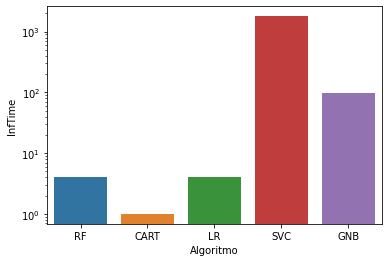

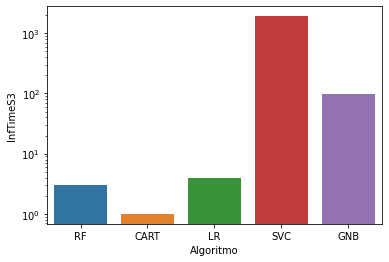

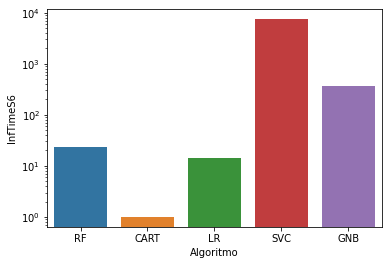

In [13]:
columns = ['InfTime', 'InfTimeS3', 'InfTimeS6']
for c in columns:
    csv = read_csv("InfTimeReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    g.set_yscale("log")
    plt.ylabel(c)
    plt.show()


# Memoria occupata

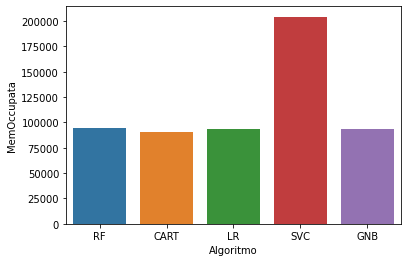

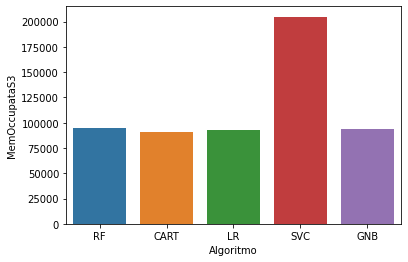

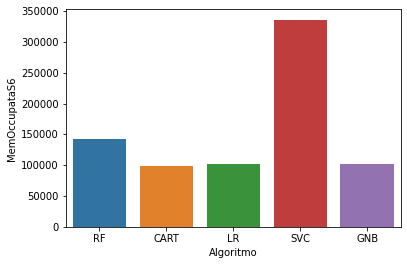

In [14]:
columns = ['MemOccupata', 'MemOccupataS3', 'MemOccupataS6']
for c in columns:   
    csv = read_csv("MemOccupationReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    plt.ylabel(c)
    plt.show()

# Neural Network

In [36]:
def getNetwork(): 
    n = 100
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    learn_rate = 0.0001 if choosenIndex == 2 else 0.001
    opt = Adam(learning_rate=learn_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [ ]:
EPOCHS = 500
BATCH_SIZE = 8
num_folds = 10


kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

# Train and Test

In [37]:
EPOCHS = 500 + (500 * choosenIndex)
BATCH_SIZE = 8

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
classification_report_csv(report, "NN")
print(report)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_40 (Dense)             (None, 1100)              36300     
_________________________________________________________________
dense_41 (Dense)             (None, 11)                12111     
Total params: 49,467
Trainable params: 49,467
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
83/83 [==============================] - 0s 1ms/step - loss: 248.6070 - accuracy: 0.0833 - val_loss: 39.7449 - val_accuracy: 0.0818
Epoch 2/1500
83/83 [==============================] - 0s 624us/step - loss: 33.9008 - accuracy: 0.0864 - val_loss: 39.5402 - val_accuracy: 0.0818
Epoch 3/1500
83/83 [==============================] - 0s 609us/step - loss: 35.9962 - ac

Epoch 52/1500
83/83 [==============================] - 0s 618us/step - loss: 20.0364 - accuracy: 0.1197 - val_loss: 20.4250 - val_accuracy: 0.0727
Epoch 53/1500
83/83 [==============================] - 0s 601us/step - loss: 17.8072 - accuracy: 0.1136 - val_loss: 18.1075 - val_accuracy: 0.0591
Epoch 54/1500
83/83 [==============================] - 0s 601us/step - loss: 19.9017 - accuracy: 0.1288 - val_loss: 22.0233 - val_accuracy: 0.0636
Epoch 55/1500
83/83 [==============================] - 0s 626us/step - loss: 25.2230 - accuracy: 0.1167 - val_loss: 18.4040 - val_accuracy: 0.0773
Epoch 56/1500
83/83 [==============================] - 0s 609us/step - loss: 25.7067 - accuracy: 0.1106 - val_loss: 34.5734 - val_accuracy: 0.1182
Epoch 57/1500
83/83 [==============================] - 0s 601us/step - loss: 21.8691 - accuracy: 0.1333 - val_loss: 24.3020 - val_accuracy: 0.0636
Epoch 58/1500
83/83 [==============================] - 0s 605us/step - loss: 18.3957 - accuracy: 0.1061 - val_loss: 37

Epoch 108/1500
83/83 [==============================] - 0s 599us/step - loss: 12.4786 - accuracy: 0.1167 - val_loss: 13.0305 - val_accuracy: 0.0955
Epoch 109/1500
83/83 [==============================] - 0s 603us/step - loss: 12.1079 - accuracy: 0.1167 - val_loss: 12.6598 - val_accuracy: 0.0818
Epoch 110/1500
83/83 [==============================] - 0s 603us/step - loss: 15.4191 - accuracy: 0.1318 - val_loss: 10.5289 - val_accuracy: 0.0818
Epoch 111/1500
83/83 [==============================] - 0s 600us/step - loss: 11.0428 - accuracy: 0.1333 - val_loss: 13.6166 - val_accuracy: 0.1000
Epoch 112/1500
83/83 [==============================] - 0s 601us/step - loss: 10.7523 - accuracy: 0.1394 - val_loss: 11.5651 - val_accuracy: 0.1227
Epoch 113/1500
83/83 [==============================] - 0s 598us/step - loss: 9.1617 - accuracy: 0.1470 - val_loss: 8.3493 - val_accuracy: 0.1182
Epoch 114/1500
83/83 [==============================] - 0s 644us/step - loss: 9.2343 - accuracy: 0.1485 - val_loss

Epoch 164/1500
83/83 [==============================] - 0s 606us/step - loss: 4.3317 - accuracy: 0.1803 - val_loss: 4.5244 - val_accuracy: 0.1364
Epoch 165/1500
83/83 [==============================] - 0s 613us/step - loss: 3.8616 - accuracy: 0.2091 - val_loss: 3.4163 - val_accuracy: 0.1227
Epoch 166/1500
83/83 [==============================] - 0s 603us/step - loss: 3.8530 - accuracy: 0.2197 - val_loss: 5.4812 - val_accuracy: 0.1909
Epoch 167/1500
83/83 [==============================] - 0s 609us/step - loss: 3.3340 - accuracy: 0.1924 - val_loss: 4.1327 - val_accuracy: 0.0955
Epoch 168/1500
83/83 [==============================] - 0s 608us/step - loss: 4.3189 - accuracy: 0.2000 - val_loss: 4.3478 - val_accuracy: 0.1364
Epoch 169/1500
83/83 [==============================] - 0s 598us/step - loss: 3.7987 - accuracy: 0.2076 - val_loss: 3.9652 - val_accuracy: 0.1318
Epoch 170/1500
83/83 [==============================] - 0s 615us/step - loss: 3.3012 - accuracy: 0.2197 - val_loss: 3.8577 -

83/83 [==============================] - 0s 612us/step - loss: 1.3617 - accuracy: 0.5106 - val_loss: 2.9353 - val_accuracy: 0.2500
Epoch 277/1500
83/83 [==============================] - 0s 607us/step - loss: 1.3294 - accuracy: 0.5121 - val_loss: 2.9130 - val_accuracy: 0.3227
Epoch 278/1500
83/83 [==============================] - 0s 616us/step - loss: 1.5129 - accuracy: 0.4439 - val_loss: 3.1068 - val_accuracy: 0.2273
Epoch 279/1500
83/83 [==============================] - 0s 603us/step - loss: 1.3246 - accuracy: 0.5212 - val_loss: 3.0091 - val_accuracy: 0.2455
Epoch 280/1500
83/83 [==============================] - 0s 620us/step - loss: 1.3308 - accuracy: 0.5227 - val_loss: 2.8490 - val_accuracy: 0.2545
Epoch 281/1500
83/83 [==============================] - 0s 593us/step - loss: 1.3160 - accuracy: 0.5121 - val_loss: 2.8585 - val_accuracy: 0.2955
Epoch 282/1500
83/83 [==============================] - 0s 618us/step - loss: 1.2110 - accuracy: 0.5515 - val_loss: 3.0492 - val_accuracy: 

83/83 [==============================] - 0s 612us/step - loss: 0.7769 - accuracy: 0.7121 - val_loss: 3.2028 - val_accuracy: 0.3000
Epoch 389/1500
83/83 [==============================] - 0s 606us/step - loss: 0.7068 - accuracy: 0.7576 - val_loss: 3.4022 - val_accuracy: 0.2773
Epoch 390/1500
83/83 [==============================] - 0s 606us/step - loss: 0.6935 - accuracy: 0.7636 - val_loss: 3.1810 - val_accuracy: 0.3318
Epoch 391/1500
83/83 [==============================] - 0s 597us/step - loss: 0.8492 - accuracy: 0.6803 - val_loss: 3.4427 - val_accuracy: 0.2545
Epoch 392/1500
83/83 [==============================] - 0s 625us/step - loss: 0.9032 - accuracy: 0.6758 - val_loss: 3.1773 - val_accuracy: 0.3045
Epoch 393/1500
83/83 [==============================] - 0s 612us/step - loss: 0.7083 - accuracy: 0.7379 - val_loss: 3.2694 - val_accuracy: 0.3364
Epoch 394/1500
83/83 [==============================] - 0s 604us/step - loss: 0.7152 - accuracy: 0.7530 - val_loss: 3.1435 - val_accuracy: 

83/83 [==============================] - 0s 633us/step - loss: 0.6301 - accuracy: 0.7606 - val_loss: 3.8084 - val_accuracy: 0.3182
Epoch 501/1500
83/83 [==============================] - 0s 625us/step - loss: 0.5466 - accuracy: 0.8045 - val_loss: 3.8636 - val_accuracy: 0.3227
Epoch 502/1500
83/83 [==============================] - 0s 597us/step - loss: 0.5339 - accuracy: 0.7970 - val_loss: 3.7199 - val_accuracy: 0.2818
Epoch 503/1500
83/83 [==============================] - 0s 608us/step - loss: 0.5454 - accuracy: 0.7909 - val_loss: 3.7963 - val_accuracy: 0.2955
Epoch 504/1500
83/83 [==============================] - 0s 611us/step - loss: 0.4727 - accuracy: 0.8227 - val_loss: 3.6364 - val_accuracy: 0.3318
Epoch 505/1500
83/83 [==============================] - 0s 621us/step - loss: 0.4513 - accuracy: 0.8576 - val_loss: 3.7284 - val_accuracy: 0.4045
Epoch 506/1500
83/83 [==============================] - 0s 614us/step - loss: 0.5007 - accuracy: 0.8121 - val_loss: 4.0043 - val_accuracy: 

83/83 [==============================] - 0s 604us/step - loss: 0.3117 - accuracy: 0.8985 - val_loss: 4.1241 - val_accuracy: 0.3727
Epoch 613/1500
83/83 [==============================] - 0s 605us/step - loss: 0.3557 - accuracy: 0.8833 - val_loss: 4.0970 - val_accuracy: 0.3273
Epoch 614/1500
83/83 [==============================] - 0s 610us/step - loss: 0.3253 - accuracy: 0.8909 - val_loss: 4.0688 - val_accuracy: 0.3591
Epoch 615/1500
83/83 [==============================] - 0s 614us/step - loss: 0.3773 - accuracy: 0.8788 - val_loss: 4.0336 - val_accuracy: 0.3864
Epoch 616/1500
83/83 [==============================] - 0s 627us/step - loss: 0.4010 - accuracy: 0.8667 - val_loss: 4.2522 - val_accuracy: 0.3364
Epoch 617/1500
83/83 [==============================] - 0s 616us/step - loss: 0.4120 - accuracy: 0.8667 - val_loss: 4.2453 - val_accuracy: 0.3545
Epoch 618/1500
83/83 [==============================] - 0s 607us/step - loss: 0.4987 - accuracy: 0.8348 - val_loss: 3.7744 - val_accuracy: 

83/83 [==============================] - 0s 627us/step - loss: 0.3740 - accuracy: 0.8788 - val_loss: 4.5131 - val_accuracy: 0.3864
Epoch 725/1500
83/83 [==============================] - 0s 605us/step - loss: 0.2829 - accuracy: 0.9045 - val_loss: 4.5503 - val_accuracy: 0.3591
Epoch 726/1500
83/83 [==============================] - 0s 614us/step - loss: 0.2886 - accuracy: 0.9000 - val_loss: 4.5322 - val_accuracy: 0.3727
Epoch 727/1500
83/83 [==============================] - 0s 601us/step - loss: 0.6390 - accuracy: 0.7758 - val_loss: 4.9593 - val_accuracy: 0.3136
Epoch 728/1500
83/83 [==============================] - 0s 599us/step - loss: 0.6156 - accuracy: 0.7909 - val_loss: 4.5030 - val_accuracy: 0.3818
Epoch 729/1500
83/83 [==============================] - 0s 630us/step - loss: 0.4114 - accuracy: 0.8515 - val_loss: 4.4255 - val_accuracy: 0.3773
Epoch 730/1500
83/83 [==============================] - 0s 618us/step - loss: 0.3861 - accuracy: 0.8758 - val_loss: 4.5602 - val_accuracy: 

83/83 [==============================] - 0s 596us/step - loss: 0.3575 - accuracy: 0.8652 - val_loss: 5.0147 - val_accuracy: 0.3364
Epoch 837/1500
83/83 [==============================] - 0s 618us/step - loss: 0.3846 - accuracy: 0.8576 - val_loss: 4.6301 - val_accuracy: 0.3545
Epoch 838/1500
83/83 [==============================] - 0s 606us/step - loss: 0.2268 - accuracy: 0.9288 - val_loss: 4.7458 - val_accuracy: 0.3818
Epoch 839/1500
83/83 [==============================] - 0s 628us/step - loss: 0.3757 - accuracy: 0.8636 - val_loss: 4.6426 - val_accuracy: 0.3500
Epoch 840/1500
83/83 [==============================] - 0s 600us/step - loss: 0.3624 - accuracy: 0.8712 - val_loss: 4.6224 - val_accuracy: 0.3636
Epoch 841/1500
83/83 [==============================] - 0s 603us/step - loss: 0.2817 - accuracy: 0.9091 - val_loss: 4.7711 - val_accuracy: 0.4045
Epoch 842/1500
83/83 [==============================] - 0s 600us/step - loss: 0.2823 - accuracy: 0.9045 - val_loss: 4.7131 - val_accuracy: 

83/83 [==============================] - 0s 595us/step - loss: 0.2477 - accuracy: 0.9197 - val_loss: 5.1284 - val_accuracy: 0.3818
Epoch 949/1500
83/83 [==============================] - 0s 602us/step - loss: 0.1940 - accuracy: 0.9455 - val_loss: 5.0033 - val_accuracy: 0.3636
Epoch 950/1500
83/83 [==============================] - 0s 607us/step - loss: 0.5690 - accuracy: 0.7985 - val_loss: 4.7653 - val_accuracy: 0.3500
Epoch 951/1500
83/83 [==============================] - 0s 603us/step - loss: 0.3629 - accuracy: 0.8803 - val_loss: 5.4405 - val_accuracy: 0.3091
Epoch 952/1500
83/83 [==============================] - 0s 618us/step - loss: 0.5164 - accuracy: 0.8167 - val_loss: 5.0616 - val_accuracy: 0.3455
Epoch 953/1500
83/83 [==============================] - 0s 603us/step - loss: 0.3203 - accuracy: 0.8758 - val_loss: 4.7564 - val_accuracy: 0.3909
Epoch 954/1500
83/83 [==============================] - 0s 607us/step - loss: 0.2153 - accuracy: 0.9273 - val_loss: 5.0993 - val_accuracy: 

Epoch 1060/1500
83/83 [==============================] - 0s 619us/step - loss: 0.2364 - accuracy: 0.9242 - val_loss: 5.1939 - val_accuracy: 0.3591
Epoch 1061/1500
83/83 [==============================] - 0s 612us/step - loss: 0.3218 - accuracy: 0.8818 - val_loss: 5.2031 - val_accuracy: 0.3727
Epoch 1062/1500
83/83 [==============================] - 0s 603us/step - loss: 0.2357 - accuracy: 0.9288 - val_loss: 5.0761 - val_accuracy: 0.3909
Epoch 1063/1500
83/83 [==============================] - 0s 613us/step - loss: 0.2355 - accuracy: 0.9212 - val_loss: 4.9746 - val_accuracy: 0.4318
Epoch 1064/1500
83/83 [==============================] - 0s 601us/step - loss: 0.2041 - accuracy: 0.9348 - val_loss: 4.9998 - val_accuracy: 0.4136
Epoch 1065/1500
83/83 [==============================] - 0s 604us/step - loss: 0.1796 - accuracy: 0.9485 - val_loss: 4.9764 - val_accuracy: 0.4227
Epoch 1066/1500
83/83 [==============================] - 0s 617us/step - loss: 0.2373 - accuracy: 0.9167 - val_loss: 5

Epoch 1116/1500
83/83 [==============================] - 0s 595us/step - loss: 1.2476 - accuracy: 0.6818 - val_loss: 5.3068 - val_accuracy: 0.3636
Epoch 1117/1500
83/83 [==============================] - 0s 611us/step - loss: 0.5677 - accuracy: 0.7848 - val_loss: 5.0024 - val_accuracy: 0.3864
Epoch 1118/1500
83/83 [==============================] - 0s 602us/step - loss: 0.1999 - accuracy: 0.9470 - val_loss: 4.9645 - val_accuracy: 0.3818
Epoch 1119/1500
83/83 [==============================] - 0s 622us/step - loss: 0.1656 - accuracy: 0.9591 - val_loss: 5.1233 - val_accuracy: 0.4182
Epoch 1120/1500
83/83 [==============================] - 0s 607us/step - loss: 0.1475 - accuracy: 0.9576 - val_loss: 4.7652 - val_accuracy: 0.4318
Epoch 1121/1500
83/83 [==============================] - 0s 607us/step - loss: 0.2261 - accuracy: 0.9242 - val_loss: 4.9199 - val_accuracy: 0.4045
Epoch 1122/1500
83/83 [==============================] - 0s 600us/step - loss: 0.2352 - accuracy: 0.9212 - val_loss: 5

Epoch 1172/1500
83/83 [==============================] - 0s 607us/step - loss: 0.2202 - accuracy: 0.9167 - val_loss: 5.0687 - val_accuracy: 0.4227
Epoch 1173/1500
83/83 [==============================] - 0s 607us/step - loss: 0.1786 - accuracy: 0.9470 - val_loss: 5.1586 - val_accuracy: 0.3500
Epoch 1174/1500
83/83 [==============================] - 0s 635us/step - loss: 0.2386 - accuracy: 0.9242 - val_loss: 5.5099 - val_accuracy: 0.3545
Epoch 1175/1500
83/83 [==============================] - 0s 610us/step - loss: 0.3252 - accuracy: 0.8879 - val_loss: 5.2148 - val_accuracy: 0.3727
Epoch 1176/1500
83/83 [==============================] - 0s 622us/step - loss: 0.4198 - accuracy: 0.8515 - val_loss: 5.2051 - val_accuracy: 0.4273
Epoch 1177/1500
83/83 [==============================] - 0s 605us/step - loss: 0.4623 - accuracy: 0.8424 - val_loss: 5.2434 - val_accuracy: 0.3591
Epoch 1178/1500
83/83 [==============================] - 0s 603us/step - loss: 0.2016 - accuracy: 0.9394 - val_loss: 5

Epoch 1228/1500
83/83 [==============================] - 0s 605us/step - loss: 0.4714 - accuracy: 0.8303 - val_loss: 5.4788 - val_accuracy: 0.3409
Epoch 1229/1500
83/83 [==============================] - 0s 622us/step - loss: 0.3778 - accuracy: 0.8591 - val_loss: 5.1523 - val_accuracy: 0.3364
Epoch 1230/1500
83/83 [==============================] - 0s 606us/step - loss: 0.3281 - accuracy: 0.8773 - val_loss: 5.5723 - val_accuracy: 0.3227
Epoch 1231/1500
83/83 [==============================] - 0s 621us/step - loss: 0.3573 - accuracy: 0.8712 - val_loss: 5.3297 - val_accuracy: 0.3955
Epoch 1232/1500
83/83 [==============================] - 0s 603us/step - loss: 0.3115 - accuracy: 0.9106 - val_loss: 5.5472 - val_accuracy: 0.2773
Epoch 1233/1500
83/83 [==============================] - 0s 606us/step - loss: 0.5076 - accuracy: 0.8182 - val_loss: 5.5480 - val_accuracy: 0.3000
Epoch 1234/1500
83/83 [==============================] - 0s 625us/step - loss: 0.9640 - accuracy: 0.6909 - val_loss: 5

Epoch 1284/1500
83/83 [==============================] - 0s 631us/step - loss: 0.1795 - accuracy: 0.9485 - val_loss: 5.5656 - val_accuracy: 0.3409
Epoch 1285/1500
83/83 [==============================] - 0s 607us/step - loss: 0.1492 - accuracy: 0.9576 - val_loss: 5.7768 - val_accuracy: 0.3636
Epoch 1286/1500
83/83 [==============================] - 0s 605us/step - loss: 0.1626 - accuracy: 0.9591 - val_loss: 5.6752 - val_accuracy: 0.3682
Epoch 1287/1500
83/83 [==============================] - 0s 626us/step - loss: 0.1305 - accuracy: 0.9697 - val_loss: 5.4387 - val_accuracy: 0.4045
Epoch 1288/1500
83/83 [==============================] - 0s 617us/step - loss: 0.5708 - accuracy: 0.8318 - val_loss: 6.8614 - val_accuracy: 0.2636
Epoch 1289/1500
83/83 [==============================] - 0s 613us/step - loss: 3.9870 - accuracy: 0.3500 - val_loss: 5.4092 - val_accuracy: 0.2818
Epoch 1290/1500
83/83 [==============================] - 0s 606us/step - loss: 2.9255 - accuracy: 0.3682 - val_loss: 3

Epoch 1340/1500
83/83 [==============================] - 0s 611us/step - loss: 0.1467 - accuracy: 0.9606 - val_loss: 5.3043 - val_accuracy: 0.4136
Epoch 1341/1500
83/83 [==============================] - 0s 607us/step - loss: 0.2751 - accuracy: 0.9015 - val_loss: 5.3595 - val_accuracy: 0.3773
Epoch 1342/1500
83/83 [==============================] - 0s 614us/step - loss: 0.3322 - accuracy: 0.8894 - val_loss: 6.0055 - val_accuracy: 0.3455
Epoch 1343/1500
83/83 [==============================] - 0s 626us/step - loss: 0.7072 - accuracy: 0.7652 - val_loss: 5.8879 - val_accuracy: 0.3318
Epoch 1344/1500
83/83 [==============================] - 0s 601us/step - loss: 0.3500 - accuracy: 0.8591 - val_loss: 5.3448 - val_accuracy: 0.3818
Epoch 1345/1500
83/83 [==============================] - 0s 621us/step - loss: 0.2925 - accuracy: 0.8955 - val_loss: 5.6166 - val_accuracy: 0.3591
Epoch 1346/1500
83/83 [==============================] - 0s 615us/step - loss: 0.1877 - accuracy: 0.9379 - val_loss: 5

Epoch 1396/1500
83/83 [==============================] - 0s 599us/step - loss: 0.1889 - accuracy: 0.9379 - val_loss: 5.7425 - val_accuracy: 0.3818
Epoch 1397/1500
83/83 [==============================] - 0s 597us/step - loss: 0.2823 - accuracy: 0.9030 - val_loss: 5.4149 - val_accuracy: 0.3864
Epoch 1398/1500
83/83 [==============================] - 0s 621us/step - loss: 0.2917 - accuracy: 0.8909 - val_loss: 6.1586 - val_accuracy: 0.2455
Epoch 1399/1500
83/83 [==============================] - 0s 606us/step - loss: 1.0751 - accuracy: 0.6879 - val_loss: 6.0846 - val_accuracy: 0.2636
Epoch 1400/1500
83/83 [==============================] - 0s 609us/step - loss: 1.0267 - accuracy: 0.6697 - val_loss: 5.4451 - val_accuracy: 0.2682
Epoch 1401/1500
83/83 [==============================] - 0s 606us/step - loss: 0.6968 - accuracy: 0.7545 - val_loss: 5.6703 - val_accuracy: 0.3636
Epoch 1402/1500
83/83 [==============================] - 0s 612us/step - loss: 0.3373 - accuracy: 0.8621 - val_loss: 5

Epoch 1452/1500
83/83 [==============================] - 0s 603us/step - loss: 0.1959 - accuracy: 0.9333 - val_loss: 5.8601 - val_accuracy: 0.3455
Epoch 1453/1500
83/83 [==============================] - 0s 613us/step - loss: 0.1412 - accuracy: 0.9682 - val_loss: 5.5703 - val_accuracy: 0.3500
Epoch 1454/1500
83/83 [==============================] - 0s 606us/step - loss: 0.1404 - accuracy: 0.9606 - val_loss: 5.3960 - val_accuracy: 0.4136
Epoch 1455/1500
83/83 [==============================] - 0s 599us/step - loss: 0.1285 - accuracy: 0.9742 - val_loss: 5.4576 - val_accuracy: 0.3727
Epoch 1456/1500
83/83 [==============================] - 0s 610us/step - loss: 0.1119 - accuracy: 0.9773 - val_loss: 5.5663 - val_accuracy: 0.3909
Epoch 1457/1500
83/83 [==============================] - 0s 606us/step - loss: 0.1647 - accuracy: 0.9470 - val_loss: 5.5044 - val_accuracy: 0.3591
Epoch 1458/1500
83/83 [==============================] - 0s 601us/step - loss: 0.3443 - accuracy: 0.8621 - val_loss: 6

# Export Models in C code

In [38]:

# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/' + 'NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmpwxpktlh6/assets


INFO:tensorflow:Assets written to: /tmp/tmpwxpktlh6/assets
